In [1]:
import math
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import numpy
import os
import time
import matplotlib.pyplot


c:\Users\blizz\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

True


In [3]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616)),
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Label: 9


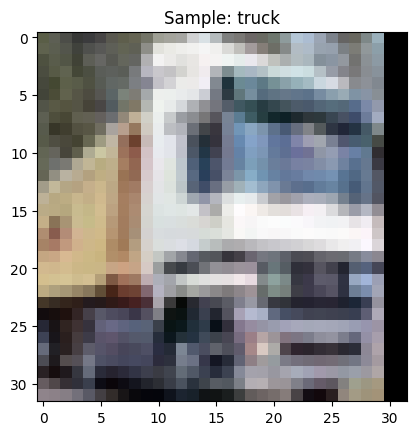

In [13]:
names = ('frog', 'dog', 'plane', 'car', 'cat', 'deer', 'bird', 'horse', 'ship', 'truck')

def denorm(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means

def show_images(images, title):
    fig, axes = matplotlib.pyplot.subplots(5, 5, figsize = (5, 5))
    fig.suptitle(title)
    matplotlib.pyplot.setp(matplotlib.pyplot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = denorm(images[i][0], params, stds)
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))

def view_image(image, title):
    img = denorm(image[0], [0.4913996756076813, 0.48215848207473755, 0.44653090834617615], [0.24703224003314972, 0.24348513782024384, 0.26158785820007324])
    img = img.numpy().transpose(1, 2, 0)
    matplotlib.pyplot.title("{}: {}".format(title, names[image[1]]))
    matplotlib.pyplot.imshow((img * 255).astype('uint8'))

ind = 1
view_image(trainset[ind], 'Sample')
print('Label: {}'.format(trainset[ind][1]))

densenet

In [4]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)

In [5]:
cnn_model = DenseNet121()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
device

device(type='cuda')

In [6]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def train(cnn_model, data_loader, epochs, loss_function, optimizer, device):
    start = time.time()
    for epoch in range(epochs):
        startep = time.time()
        accs = []
        lss = []

        for i, (images, labels) in enumerate(data_loader):

            images = images.to(device)
            labels = labels.to(device)

            #print(1)
            optimizer.zero_grad()
            #print(2)
            outputs = cnn_model(images)
            #print(3)
            loss = loss_function(outputs, labels)
            #print(4)
            loss.backward()
            #print(5)
            optimizer.step()

            acc = accuracy(outputs, labels)
            lss.append(loss)
            accs.append(acc)

            endep = time.time()

        print('Epoch {}: loss = {}, acc = {}, time = {}'.format(epoch + 1, torch.stack(lss).mean(), torch.stack(accs).mean(), endep-startep))
    end = time.time()
    print('Total time {}'.format(end - start))


In [7]:
train(cnn_model, trainloader, 100, loss_function, optimizer, device)

Epoch 1: loss = 1.5604145526885986, acc = 0.42161989212036133, time = 72.50375604629517
Epoch 2: loss = 1.048887014389038, acc = 0.6250039935112, time = 70.76117587089539
Epoch 3: loss = 0.8009975552558899, acc = 0.7154416441917419, time = 70.6006510257721
Epoch 4: loss = 0.6494734883308411, acc = 0.7731943726539612, time = 70.63005685806274
Epoch 5: loss = 0.5500002503395081, acc = 0.8076609969139099, time = 70.62505197525024
Epoch 6: loss = 0.48343899846076965, acc = 0.8328921794891357, time = 70.59202265739441
Epoch 7: loss = 0.43238669633865356, acc = 0.8498286008834839, time = 70.5716142654419
Epoch 8: loss = 0.3966194689273834, acc = 0.8621851205825806, time = 70.57600784301758
Epoch 9: loss = 0.3623863458633423, acc = 0.8727240562438965, time = 71.14452314376831
Epoch 10: loss = 0.3337022662162781, acc = 0.8830835819244385, time = 70.7501654624939
Epoch 11: loss = 0.31314313411712646, acc = 0.8917809128761292, time = 70.86126637458801
Epoch 12: loss = 0.3008894622325897, acc = 0

In [8]:
print('Loss = {}, acc = {}'.format(get_loss(cnn_model, testloader, device), get_accuracy(cnn_model, testloader, device)))

Loss = 0.0018476194236427546, acc = 0.8690999746322632
